In [2]:
import warnings
warnings.filterwarnings('ignore')

import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

In [4]:
import os

data_dir = '../datasets/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [5]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [7]:
from matplotlib import pyplot as plt

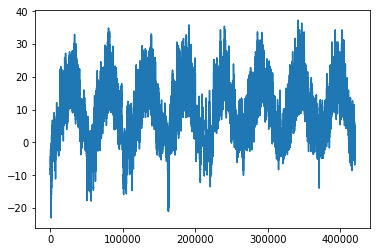

In [9]:
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

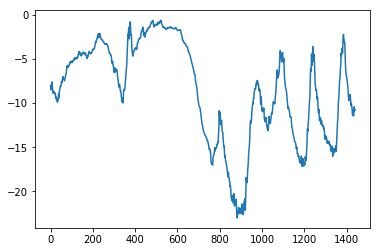

In [10]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [11]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data.std(axis=0)
float_data /= std

In [31]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [32]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

```python
np.mean(np.abs(preds - targets))
```

In [33]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.3044971244105931


In [36]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 10s 21ms/step - loss: 1.6163 - val_loss: 0.7662
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 0.5902 - val_loss: 0.4215
Epoch 3/20
500/500 [==============================] - 10s 20ms/step - loss: 0.3327 - val_loss: 0.3042
Epoch 4/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2970 - val_loss: 0.3289
Epoch 5/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2824 - val_loss: 0.3204
Epoch 6/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2726 - val_loss: 0.3432
Epoch 7/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2639 - val_loss: 0.3061
Epoch 8/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2581 - val_loss: 0.3289
Epoch 9/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2529 - val_loss: 0.3246
Epoch 10/20
500/500 [==============================] - 10s 20ms/step - loss: 0.248

In [37]:
import matplotlib.pyplot as plt

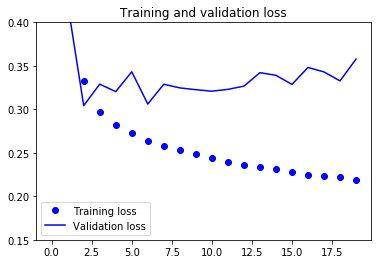

In [40]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim([0.15, 0.4])
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 175s 350ms/step - loss: 0.3186 - val_loss: 0.2835
Epoch 2/20
500/500 [==============================] - 174s 347ms/step - loss: 0.3020 - val_loss: 0.2842
Epoch 3/20
500/500 [==============================] - 175s 349ms/step - loss: 0.2966 - val_loss: 0.2864
Epoch 4/20
500/500 [==============================] - 174s 349ms/step - loss: 0.2890 - val_loss: 0.2800
Epoch 5/20
500/500 [==============================] - 175s 349ms/step - loss: 0.2841 - val_loss: 0.2820
Epoch 6/20
500/500 [==============================] - 174s 349ms/step - loss: 0.2796 - val_loss: 0.2796
Epoch 7/20
500/500 [==============================] - 174s 348ms/step - loss: 0.2738 - val_loss: 0.2826
Epoch 8/20
500/500 [==============================] - 174s 347ms/step - loss: 0.2691 - val_loss: 0.2860
Epoch 9/20
 85/500 [====>.........................] - ETA: 1:47 - loss: 0.2657

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        

val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)
test_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)